# Tensorflow LSTM

In [1]:
import pandas as pd
import pandas_ta as ta
import yfinance as yf

import os 
os.environ['HTTP_PROXY'] = "http://127.0.0.1:7890" 
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:7890" 

In [2]:
# download BTC-USD data
df = pd.DataFrame().ta.ticker("BTC-USD", start="2021-01-01", interval="1D",proxy="http://127.0.0.1:7890") 

In [3]:
# data normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

df[['Open','Close','High','Low']] = scaler.fit_transform(df[['Open','Close','High','Low']])

# reset pandas index
df['Date'] = df.index
df.index = df.pop('Date')


In [4]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-01 00:00:00+00:00,-0.573219,-0.578455,-0.544106,-0.558267,40730301359,0,0
2021-01-02 00:00:00+00:00,-0.557614,-0.435287,-0.532289,-0.445939,67865420765,0,0
2021-01-03 00:00:00+00:00,-0.445283,-0.376745,-0.410615,-0.419225,78665235202,0,0
2021-01-04 00:00:00+00:00,-0.417473,-0.423804,-0.547427,-0.452278,81163475344,0,0
2021-01-05 00:00:00+00:00,-0.451500,-0.383631,-0.485857,-0.369840,67547324782,0,0
...,...,...,...,...,...,...,...
2022-10-13 00:00:00+00:00,-0.974607,-0.987168,-0.974886,-0.965911,44219840004,0,0
2022-10-14 00:00:00+00:00,-0.965403,-0.969614,-0.942195,-0.973959,38452356727,0,0
2022-10-15 00:00:00+00:00,-0.973445,-0.996866,-0.946146,-0.978774,16192235532,0,0


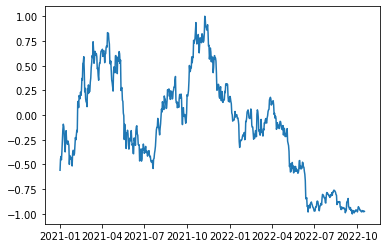

In [5]:
# data show
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [6]:
import numpy as np
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

In [7]:
# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-25', 
                                n=3)

/tmp/ipykernel_81124/4081963781.py:20: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  df_subset = dataframe.loc[:target_date].tail(n+1)
/tmp/ipykernel_81124/4081963781.py:33: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]


In [8]:
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,0.468061,0.476620,0.396461,0.352801
1,2021-03-26,0.476620,0.396461,0.352801,0.492874
2,2021-03-27,0.396461,0.352801,0.492874,0.526991
3,2021-03-28,0.352801,0.492874,0.526991,0.526062
4,2021-03-29,0.492874,0.526991,0.526062,0.599480
...,...,...,...,...,...
361,2022-03-21,-0.051243,-0.035352,-0.073819,-0.080748
362,2022-03-22,-0.035352,-0.073819,-0.080748,-0.028491
363,2022-03-23,-0.073819,-0.080748,-0.028491,-0.006698
364,2022-03-24,-0.080748,-0.028491,-0.006698,0.036876


In [9]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

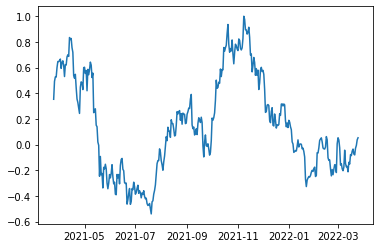

In [10]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

plt.plot(dates, y)

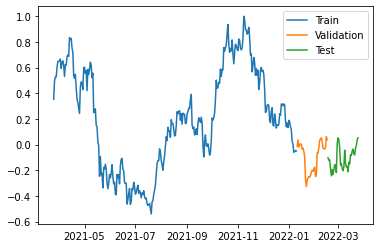

In [11]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential(name="TensorFlow-LSTM-Model",
                   layers=[layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.summary()

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

2022-10-17 11:40:21.102992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 11:40:21.130778: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-10-17 11:40:21.130796: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-17 11:40:21.131654: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

Model: "TensorFlow-LSTM-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20,065
Trainable params: 20,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10/10 [==============================] - 1s 37ms/step - loss: 0.1804 - mean_absolute_error: 0.3543 - val_loss: 0.0232 - val_mean_absolute_error: 0.1164
Epoch 2/1

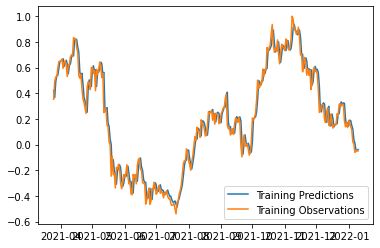

In [13]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

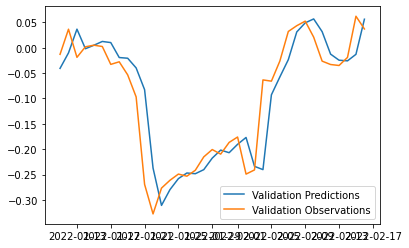

In [14]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

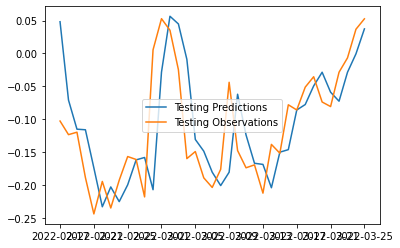

In [15]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

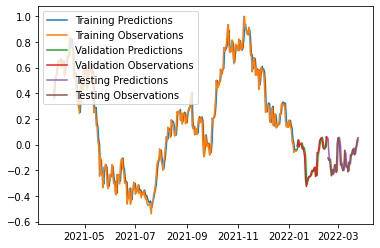

In [16]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [17]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

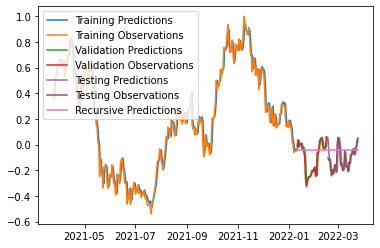

In [18]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])